<a href="https://colab.research.google.com/github/Myrto-Iglezou/AI2-project2/blob/master/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YΣ19 Artificial Intelligence II
# Homework 2

### Iglezou Myrto - 111520170038

# Model 2

In [1]:
import pandas as pd 
from pandas import DataFrame, read_csv

In [2]:
import gdown
url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
output = "twitterData.csv"
gdown.download(path, output, quiet=True)
twitterData = pd.read_csv("/content/twitterData.csv")
df = pd.DataFrame(data=twitterData)
df.head(5)

# path = r"C:\Users\myrto\Documents\GitHub\AI2-project2\SentimentTweets.csv"
# file = pd.read_csv(path,index_col=False)
# # file = pd.read_csv(path,index_col=False,nrows=50000)
# df = pd.DataFrame(data=file)
# df.head(5)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [3]:
df['target'].replace({4: 1}, inplace = True)
X = df['text']
y = df['target']

## Data pre-processing

### Removing the scpecial characters

In [4]:
import re

def RemoveSpecialCharacters(x):
    x = re.sub(r'[^\w]+', " ", x)
    return x

In [5]:
X = X.apply(lambda x: RemoveSpecialCharacters(x) )

### Lemmatize

In [6]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

X = X.apply(lambda x: WordNetLemmatizer().lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
X = X.apply(lambda x: x.lower())

### Removing the upercase

In [8]:
X = X.apply(lambda x: x.lower())

## Vectorizing

In [9]:
def vectorizeData(X_train,X_test,X_val,vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_val = vectorizer.transform(X_val)
    
    return X_train,X_test,X_val

In [10]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3,   random_state = 4, stratify = y)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

split_int = int(len(train_X)*0.8)

train_X, val_X = train_X[:split_int], train_X[split_int:]
train_y, val_y = train_y[:split_int], train_y[split_int:]

tv = TfidfVectorizer(max_features=500)
X_train, X_test, X_val =  vectorizeData(train_X, test_X, val_X, tv)

X_train = X_train.toarray()
y_train = train_y.values

X_val = X_val.toarray()
y_val = val_y.values

X_test = X_test.toarray()
y_test = test_y.values


## Batching sentences together with a DataLoader

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# bach size
batch_size = 100

# dataloader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

## Architecture of NN

In [67]:
class Model_2(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes = 1):
        super(Model_2, self).__init__()
     
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [68]:
def train(model,X,y,optimizer,loss_fn):

    # step 1. Zero the gradients
#         model.zero_grad()
        optimizer.zero_grad()
    # step 2. Compute the output
        y_pred = model(X)
    # step 3. Compute the loss
        loss = loss_fn(y_pred.squeeze(), y)
    # step 4. use loss to produce gradients
        loss.backward()
    # step 5. use optimizer to take gradient step
        optimizer.step()
    
        return loss.item()

In [69]:
def validate(classifier,X,y,loss_fn):
  y_pred =  classifier(X)
  loss = loss_fn(y_pred.squeeze(), y)

  return loss.item()


In [70]:
def predict(model,X):
    outputs = model(X)
    return torch.round(outputs)

In [71]:
import matplotlib.pyplot as plt

def plot_losses(list_of_losses,valid_losses,title):
    plt.figure(figsize=(8,5))

    plt.plot(valid_losses,'o-',color="r")

    plt.plot(list_of_losses,'o-',color="g")

    plt.grid()

    plt.plot(valid_losses, 'o-', color="r",
                    label="Validation loss")
    plt.plot(list_of_losses,  'o-', color="g",
                    label="Training loss")

    plt.legend(loc="best")

    plt.xlabel("epochs")
    plt.ylabel("losses")
    plt.title(title)

    plt.show()

In [72]:
def training(net,train_loader,valid_loader,optimizer, loss_function,num_epochs = 5):

  list_of_losses = []
  valid_losses = []

  for epoch in range(num_epochs):
      running_loss = 0.0
      net.train()
      for batch_index, batch in (enumerate(train_loader)):
          x_train, y_train = batch[0], batch[1]
          x_train = x_train.float()
          y_train = y_train.float()
          
          loss_t = train(net,x_train,y_train,optimizer,loss_function)       
          running_loss += (loss_t - running_loss) / (batch_index + 1)
                
      list_of_losses.append(running_loss)

      running_loss = 0.0
      net.train()
      for batch_index, batch in (enumerate(valid_loader)):
          x_train, y_train = batch[0], batch[1]
          x_train = x_train.float()
          y_train = y_train.float()
          
          loss_t = validate(net,x_train,y_train,loss_function)       
          running_loss += (loss_t - running_loss) / (batch_index + 1)
      valid_losses.append(running_loss)
       
  return list_of_losses,valid_losses

In [73]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score

def testing(net,test_loader):
  accuracy = []
  f1 = []
  recall = []
  precision = []

  for bidx, batch in (enumerate(test_loader)):
      x_test, y_test = batch[0], batch[1]
      x_test = x_test.float()
      y_test = y_test.float()
      y_test = y_test.numpy()
      y_pred = predict(net,x_test)
      y_pred = y_pred.detach().numpy()
      
      acc = accuracy_score(y_test, y_pred)
      f1_sc = f1_score(y_test, y_pred, average='macro')
      rec = recall_score(y_test, y_pred, average='macro')
      prec = precision_score(y_test, y_pred, average='macro')
      
      accuracy.append(acc)
      f1.append(f1_sc)
      recall.append(rec)
      precision.append(prec)

  return np.mean(accuracy),np.mean(f1),np.mean(recall),np.mean(precision)
    

In [74]:
df = pd.DataFrame(columns=[['Num of neurons','Accuracy','F1-score','Recall-score','Precision']])

## Training



In [76]:
nlearning_rate = 0.0001
net = Model_2(len(X_train[0]),hidden_size = 50) 
op = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
lf = nn.BCELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

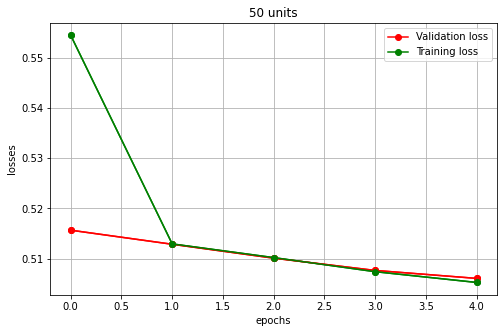

In [77]:
title=("50 units")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [78]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["50",acc,f1,recall,precision]

## **100 Units**

In [80]:
nlearning_rate = 0.0001
net = Model_2(len(X_train[0]),hidden_size = 100) 
op = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
lf = nn.BCELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

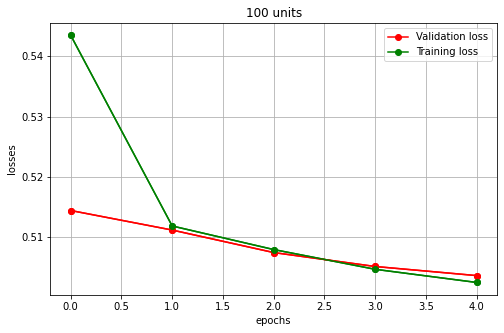

In [81]:
title=("100 units")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [82]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["100",acc,f1,recall,precision]

## **500 Units**

In [83]:
nlearning_rate = 0.0001
net = Model_2(len(X_train[0]),hidden_size = 500) 
op = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
lf = nn.BCELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

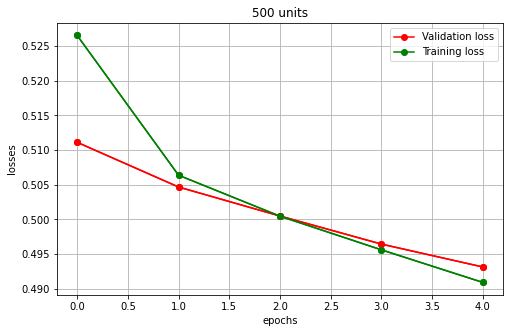

In [84]:
title=("500 units")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [85]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["500",acc,f1,recall,precision]

## **1000 Units**

In [86]:
nlearning_rate = 0.0001
net = Model_2(len(X_train[0]),hidden_size = 1000) 
op = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
lf = nn.BCELoss()
list_of_losses,valid_losses = training(net,train_loader,valid_loader,op, lf)

## Check for Overfitting-Underfitting

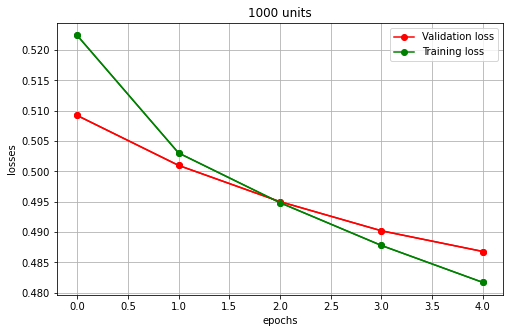

In [87]:
title=("1000 units")
plot_losses(list_of_losses,valid_losses,title)

## Test and save scores

In [88]:
acc, f1,recall,precision = testing(net,test_loader)
df.loc[len(df)] = ["1000",acc,f1,recall,precision]

## **Scores**

In [89]:
df

,Num of neurons,Accuracy,F1-score,Recall-score,Precision
0,50,0.749849,0.747885,0.749772,0.749661
1,100,0.751820,0.749882,0.751731,0.751703
2,500,0.759510,0.757638,0.759590,0.759580
3,1000,0.763263,0.761383,0.763202,0.763336


## **Remarks**



*   For this model we used only two layers, an input, with ReLU as activation, function and an output, with sigmoid as activation function, layer and we experiment with the input size of the second one.
*   We can observe that, while increasing the number of units of the layer the scores are getting higher.

